<a href="https://colab.research.google.com/github/Helios109/Verylimitedtoystore/blob/main/COMPLETE_Customers_clustering_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 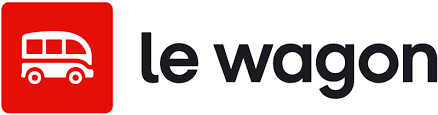

# Orders clustering

The purpose of the exercise is to extract different "typical profiles" of orders and consumers from Greenweez's turnover data. To achieve this, we will apply unsupervised learning algorithms to create order clusters.

## Orders clustering

a) Execute the cell below to load  the data into a `df` variable.

It will select 50k orders randomly (`ORDER BY rand()` in the SQL query).

In [1]:
from google.colab import auth
import pandas as pd

# get credentials
auth.authenticate_user()

query = '''
SELECT turnover_grocery, turnover_beauty, turnover_baby, turnover_home, turnover_fresh, promo_rate
FROM `data-analytics-bootcamp-363212.course33.gwz_orders_segmentation`
ORDER BY rand()
LIMIT 50000
'''
df = pd.read_gbq(query, project_id="data-analytics-bootcamp-363212")
df.head()

turnover_grocery  turnover_beauty  turnover_baby  turnover_home  \
0             36.69            12.18           0.00           3.56   
1             17.58            20.11           0.00           0.00   
2              0.00            60.33           0.00           0.00   
3              5.47             9.15          74.55           3.16   
4              0.00             0.00           0.00          23.73   

   turnover_fresh  promo_rate  
0             0.0    0.014429  
1             0.0         NaN  
2             0.0    0.004492  
3             0.0    0.145067  
4             0.0         NaN

b) Which features do you see?

In [5]:
print(df.columns)


Index(['turnover_grocery', 'turnover_beauty', 'turnover_baby', 'turnover_home',
       'turnover_fresh', 'promo_rate'],
      dtype='object')


Are there any null values?

In [6]:
print(df.isnull().sum())


turnover_grocery        0
turnover_beauty         0
turnover_baby           0
turnover_home           0
turnover_fresh          0
promo_rate          16018
dtype: int64


c) Replace null values (if any exist) with 0 using `fillna()`

In [7]:
df['promo_rate'].fillna(0, inplace=True)


In [8]:
print(df.isnull().sum())

turnover_grocery    0
turnover_beauty     0
turnover_baby       0
turnover_home       0
turnover_fresh      0
promo_rate          0
dtype: int64


d) In a variable called `df_orders`, keep all the turnover columns from the original df. These features will help us cluster orders.

In [10]:
df_orders = df[['turnover_grocery', 'turnover_beauty', 'turnover_baby', 'turnover_home', 'turnover_fresh']]


e) Use plotly.express and a box chart to see if the distribution of turnover is different per category (i.e. feature).

In [11]:
import plotly.express as px

# Create a box plot #
fig = px.box(df_orders, title="Turnover Distribution per Category",
             labels={'variable': 'Category', 'value': 'Turnover'},
             boxmode='overlay')

# Update layout #
fig.update_layout(xaxis={'categoryorder':'total descending'})

# Show the plot #
fig.show()


f) Most entries for the column 'turnover_fresh' do not differ from zero, it seems like people are not purchasing these products enough to conduct a meaningful analysis.

Delete the `turnover_fresh` column from `df_orders`.

In [ ]:
df_orders.drop(columns=['turnover_fresh'], inplace=True)


g) Train a first kmeans algorithm with two a-priori clusters. Remember that distance based models, such as k-means, are greatly effected by scale. Be sure to standardize your data appropriately.


In [18]:
from sklearn.preprocessing import StandardScaler

# Standardize the data #
scaler = StandardScaler()
df_orders_scaled = scaler.fit_transform(df_orders)

# Train KMeans algorithm with two clusters #
from sklearn.cluster import KMeans

# Define the number of clusters #
n_clusters = 2

# Initialize KMeans #
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit KMeans to the standardized data #
kmeans.fit(df_orders_scaled)

# Extract cluster labels #
cluster_labels = kmeans.labels_


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



h) What is inertia for a clustering algorithm? What is inertia for this model?

Inertia, or within-cluster sum of squares is a metric used to evaluate the performance of a clustering algorithm, particularly for algorithms like KMeans. It measures how tightly grouped the samples in each cluster are.

In [19]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)



i) How do we know if 2 clusters a priori was a good choice or not?
Which method could you use?

The elbow method will allow of to check inertias with differing numbers of starting clusters.

j) You will use elbow method.

You will need to loop over different values of  𝑘  (in range 1 to 10) and stores the inertia at each iteration in order to plot its evolution and select the best  𝑘.

Complete code below to do so.

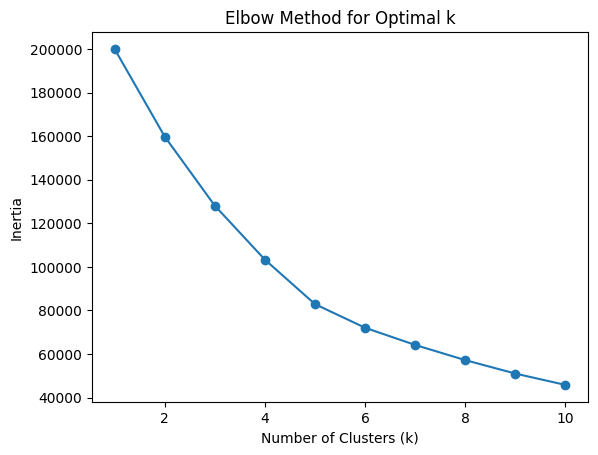

In [25]:
inertias = []
n_k = range(1, 11)  # Range from 1 to 10 #

# Loop over different values of k #
for k in n_k:
    # Initialize KMeans with current k and explicitly set n_init #
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

    # Fit KMeans to the standardized data #
    kmeans.fit(df_orders_scaled)

    # Append the inertia to the list #
    inertias.append(kmeans.inertia_)

# Plot the elbow curve #
import matplotlib.pyplot as plt

plt.plot(n_k, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


k) Which number of cluster you recommend and why?

In [26]:
import pandas as pd

# Create a DataFrame to store inertia values #
inertia_df = pd.DataFrame({'Number of Clusters (k)': n_k, 'Inertia': inertias})

# Display the DataFrame #
print(inertia_df)


   Number of Clusters (k)        Inertia
0                       1  200000.000000
1                       2  159804.005350
2                       3  128071.115193
3                       4  103300.432235
4                       5   82886.286598
5                       6   72032.982186
6                       7   64148.222025
7                       8   57178.799323
8                       9   51009.643526
9                      10   45802.096127


<details>
    <summary><i>Solution</i></summary>

It seems like the largest decreases in inertia occur from 1 -> 2 centroids and then 2 -> 3 centroids. Accordingly, choosing 3 centroids seems like a sensible place to start.
</details> This is not the case with my clusters where 4/5 are likely the most sensible places to start. 4 for simpler. 5 for more granularilty. So I'll try for 5.

l) Train a new model with 3 (5 for me) clusters a priori. Use parameter n_init=100 to select best model among 100 tries.

Use `predict()` method to predict in which cluster each row of `df_orders` belong to. We will store results in a `labels` variable.

In [31]:
# Train KMeans algorithm with 5 clusters and n_init=100 #
kmeans = KMeans(n_clusters=5, random_state=42, n_init=100)

# Fit KMeans to the standardized data #
kmeans.fit(df_orders_scaled)

# Predict cluster labels for each row of df_orders #
labels = kmeans.predict(df_orders_scaled)


m) Use [countplot](https://seaborn.pydata.org/generated/seaborn.countplot.html) function of seaborn library to count visualize number of samples per cluster. It is well distributed?

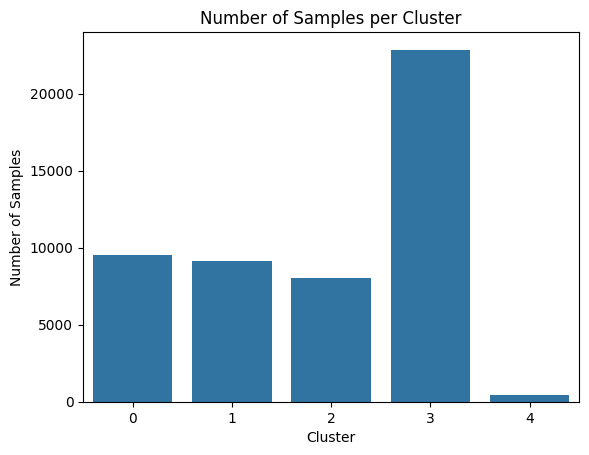

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create countplot #
sns.countplot(x=labels)
plt.xlabel('Cluster')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Cluster')
plt.show()


In [30]:
import pandas as pd

# Create a DataFrame to store cluster labels and their counts #
cluster_counts = pd.DataFrame({'Cluster': range(5), 'Count': pd.Series(labels).value_counts().sort_index()})

# Print the DataFrame #
print(cluster_counts)


   Cluster  Count
0        0   9547
1        1   9162
2        2   8023
3        3  22850
4        4    418


As cluster 4 has a significantly lower count of only 418 samples suggests that cluster 4 may not be as well-defined or representative as the other clusters. We'll try again with 4 clusters to see if this gives us a better distribution.

In [32]:
# Train KMeans algorithm with 4 clusters and n_init=100 #
kmeans = KMeans(n_clusters=4, random_state=42, n_init=100)

# Fit KMeans to the standardized data #
kmeans.fit(df_orders_scaled)

# Predict cluster labels for each row of df_orders #
labels = kmeans.predict(df_orders_scaled)

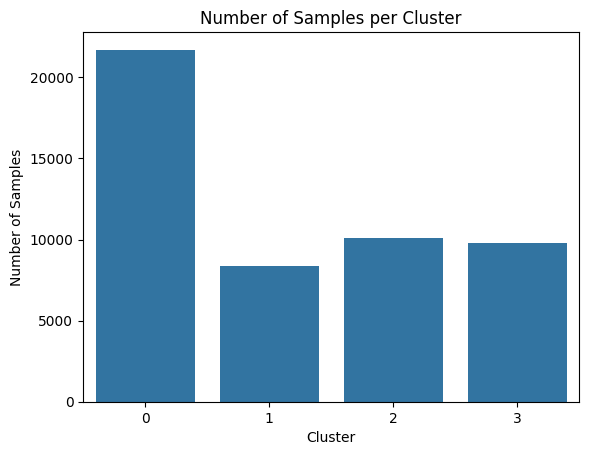

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create countplot #
sns.countplot(x=labels)
plt.xlabel('Cluster')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Cluster')
plt.show()

In [34]:
import pandas as pd

# Create a DataFrame to store cluster labels and their counts #
cluster_counts = pd.DataFrame({'Cluster': range(4), 'Count': pd.Series(labels).value_counts().sort_index()})

# Print the DataFrame #
print(cluster_counts)

   Cluster  Count
0        0  21707
1        1   8361
2        2  10122
3        3   9810


One bigger cluster... but overall, orders are well distributed.

n) Each KMeans cluster has a center (centroid).

You can get the values of the center for each cluster using the `.cluster_centers_` attribute on your KMeans object.

Create a DataFrame with each cluster's centroid values and the names of the features that the model has been trained on.

In [35]:
# Get cluster centroid values #
cluster_centers = kmeans.cluster_centers_

# Create DataFrame with centroid values and feature names #
centroid_df = pd.DataFrame(cluster_centers, columns=df_orders.columns)

# Print the DataFrame #
print(centroid_df)


   turnover_grocery  turnover_beauty  turnover_baby  turnover_home
0         -0.350851        -0.351454      -0.337478       0.317200
1         -0.506038        -0.510307       1.828031      -0.311018
2         -0.336726         1.522269      -0.381741      -0.184914
3          1.554904        -0.360151      -0.412496      -0.247013


o) What conclusions can you draw? What are the different order profiles that emerge?

<details>
    <summary><i>Solution</i></summary>

Remember that the values in each column are the relative coordinates for each centroid across the features. The greater the magnitude of a feature for a cluster, the more important that feature is to that cluster.

In the example above we can see 3 types of orders : 1 with mostly groceries, 1 with baby products and 1 that is more evenly distributed mainly mixing beauty and home products.
</details>   
Cluster 0:

    Low turnover in grocery, beauty, and baby products
    Relatively higher turnover in home products
    * This could represent customers who prioritize home-related purchases over other categories.

Cluster 1:

    Lowest turnover in grocery and beauty products
    Highest turnover in baby products
    Negative turnover in home products
    * They show negative turnover in home products, indicating that they may not purchase home products frequently.

Cluster 2:

    Relatively low turnover in grocery and home products
    Highest turnover in beauty products
    Moderate turnover in baby products
   
Cluster 3:

    Highest turnover in grocery products
    Lowest turnover in beauty and baby products
    Negative turnover in home products
    * They show negative turnover in home products, indicating a potential focus on grocery purchases.

The differing order profiles highlight the diversity of customer behavior captured by the clustering algorithm, which may provide valuable insights for targeted marketing strategies and product recommendations

p) Add to `df` a new column label containing labels of each sample.

In [36]:
# Add the 'label' column to the DataFrame 'df' #
df['label'] = labels

# Display the updated DataFrame #
print(df.head())


   turnover_grocery  turnover_beauty  turnover_baby  turnover_home  \
0             36.69            12.18           0.00           3.56   
1             17.58            20.11           0.00           0.00   
2              0.00            60.33           0.00           0.00   
3              5.47             9.15          74.55           3.16   
4              0.00             0.00           0.00          23.73   

   turnover_fresh  promo_rate  label  
0             0.0    0.014429      0  
1             0.0    0.000000      0  
2             0.0    0.004492      2  
3             0.0    0.145067      1  
4             0.0    0.000000      0  


q) What does this instruction do? What can you say?

In [37]:
df[df["promo_rate"] > 0].groupby("label").size() / df.groupby("label").size()

label
0    0.608467
1    0.647411
2    0.750939
3    0.790418
dtype: float64

This instruction calculates the proportion of samples with a non-zero promotional rate (promo_rate > 0) within each cluster and then divides it by the total number of samples in each cluster.This analysis provides insights into the distribution of promotional rates among different clusters. Clusters with higher proportions of samples with non-zero promotional rates may represent segments of customers who are more responsive to promotions or engage more frequently with promotional offers.

Where the promotion rate is greater than zero, we can see that the cluster we have associated with greater grocery turnover uses promotion codes more than others.